<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/portfolio/momentum_portfolio_manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install riskfolio-lib --q

In [3]:
import riskfolio as rp
import warnings

warnings.filterwarnings("ignore")

In [6]:
import pandas as pd
import yfinance as yf

def get_nifty50_tickers():
    data = pd.read_csv('/content/ind_nifty500list.csv', sep=',')
    nifty100 = data['Symbol'].apply(lambda x: x + ".NS").tolist()
    return nifty100


def fetch_stock_data(symbol, start_date, end_date):
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    return stock_data

In [13]:
nifty50_tickers = get_nifty50_tickers()

start_date = '2018-11-01'
end_date = '2020-01-01'

In [15]:
# Define the rolling windows for different time periods
rolling_periods = [21, 63, 126, 262]
top_decile_stocks = []
# Calculate rolling returns for each time period
for symbol in nifty50_tickers:
  try:
    stock_data = fetch_stock_data(symbol, start_date, end_date)

    if len(stock_data) > 262:
        returns_21 = stock_data['Close'].pct_change(21)
        returns_63 = stock_data['Close'].pct_change(63)
        returns_126= stock_data['Close'].pct_change(126)
        returns_252= stock_data['Close'].pct_change(252)


        # Append relevant information to the list
        top_decile_stocks.append({
            'Symbol': symbol,
            'Close': stock_data['Close'].iloc[-1],
            'returns_21': returns_21.iloc[-1],
            'returns_63': returns_63.iloc[-1],
            'returns_126':returns_126.iloc[-1],
            'returns_252':returns_252.iloc[-1],
        })
  except:
      pass


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ADANIENSOL.NS']: Exception("%ticker%: Data doesn't exist for startDate = 1541010600, endDate = 1577817000")
[***********

In [16]:
top_decile_stocks[0:10]

[{'Symbol': '3MINDIA.NS',
  'Close': 21304.69921875,
  'returns_21': -0.04213026318747404,
  'returns_63': 0.06194821048487342,
  'returns_126': -0.08105629942384085,
  'returns_252': -0.07224043350537024},
 {'Symbol': 'ABB.NS',
  'Close': 1285.25,
  'returns_21': -0.02217580290106924,
  'returns_63': -0.030280256010179807,
  'returns_126': -0.09195094098430756,
  'returns_252': 0.01146276070188934},
 {'Symbol': 'ACC.NS',
  'Close': 1445.6500244140625,
  'returns_21': -0.050257858143416545,
  'returns_63': -0.12174600921565759,
  'returns_126': -0.07005244025186275,
  'returns_252': -0.03751662821966539},
 {'Symbol': 'AIAENG.NS',
  'Close': 1649.5,
  'returns_21': 0.003192945111753165,
  'returns_63': -0.08353472657463656,
  'returns_126': -0.055863990011908005,
  'returns_252': 0.017205244717632295},
 {'Symbol': 'APLAPOLLO.NS',
  'Close': 187.77000427246094,
  'returns_21': 0.19908044834598604,
  'returns_63': 0.3831534567329524,
  'returns_126': 0.21956294442655033,
  'returns_252': 

In [17]:

# Create the DataFrame
df = pd.DataFrame(top_decile_stocks)

# Calculate composite scores
df['Composite Score'] = df[['returns_21', 'returns_63', 'returns_126', 'returns_252']].mean(axis=1)

# Sort by composite score (descending) and assign ranks
df['Rank'] = df['Composite Score'].rank(ascending=False,method='dense')

# Display the results
df[['Symbol', 'Composite Score', 'Rank']].head(10)

,Symbol,Composite Score,Rank
0,3MINDIA.NS,-0.033370,257.0
1,ABB.NS,-0.033236,256.0
2,ACC.NS,-0.069893,304.0
3,AIAENG.NS,-0.029750,252.0
4,APLAPOLLO.NS,0.322433,20.0
5,AUBANK.NS,0.152049,83.0
6,AARTIDRUGS.NS,0.117571,104.0
7,AARTIIND.NS,0.040292,164.0
8,AAVAS.NS,0.512406,4.0
9,ABBOTINDIA.NS,0.372331,15.0


In [18]:
# Sort by Composite Score in descending order
df = df.sort_values(by=['Composite Score'], ascending=False)

# Assign ranks based on sorted order
#df['Rank'] = np.arange(len(df)) + 1

# Display the results (top 10 only)
print(df[['Symbol', 'Composite Score', 'Rank']].head(10))

            Symbol  Composite Score  Rank
11   ADANIGREEN.NS         1.945346   1.0
71          BCG.NS         0.719359   2.0
111       DIXON.NS         0.514540   3.0
8         AAVAS.NS         0.512406   4.0
270   NAM-INDIA.NS         0.508693   5.0
177        ISEC.NS         0.498161   6.0
36   AVANTIFEED.NS         0.460348   7.0
247  MANAPPURAM.NS         0.435157   8.0
160     HDFCAMC.NS         0.425681   9.0
116         EPL.NS         0.416866  10.0


In [19]:
assets=df['Symbol'].head(10).tolist()
Uc_assets = [x.upper() for x in assets]


In [20]:
assets_dataframe=yf.download(assets,start=start_date,end=end_date)['Close']
Y= assets_dataframe[Uc_assets].pct_change().dropna()

[*********************100%%**********************]  10 of 10 completed


In [23]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'UCI' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0.0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)



In [24]:
display(w.T*100)

,ADANIGREEN.NS,BCG.NS,DIXON.NS,AAVAS.NS,NAM-INDIA.NS,ISEC.NS,AVANTIFEED.NS,MANAPPURAM.NS,HDFCAMC.NS,EPL.NS
weights,6.439507,1.746113,1.527582e-07,42.094723,3.090255,0.810494,1.888289e-08,13.852952,19.46286,12.503095


In [ ]:
display(w.T*100)

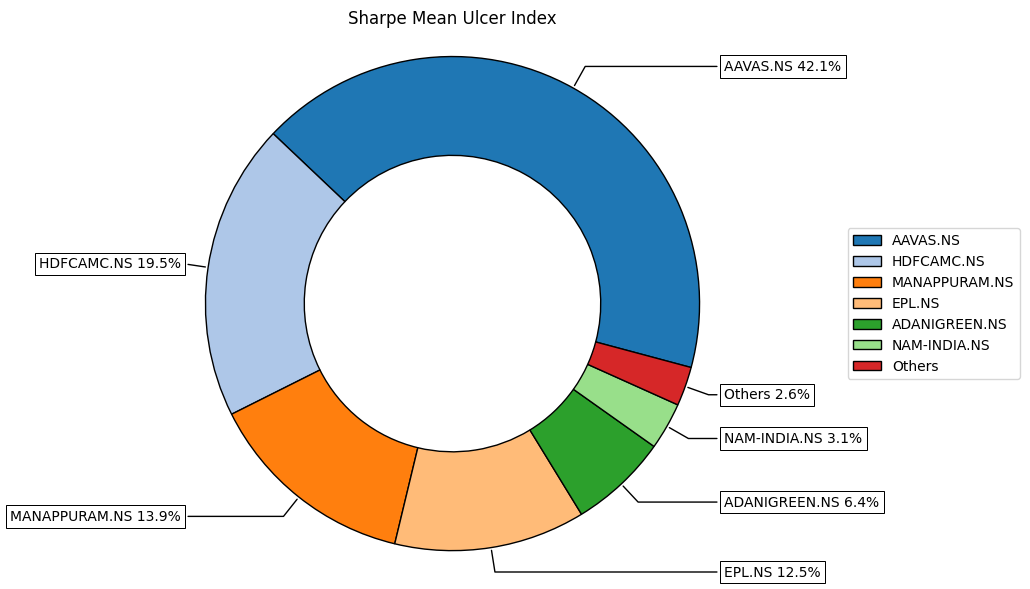

In [25]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Ulcer Index', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

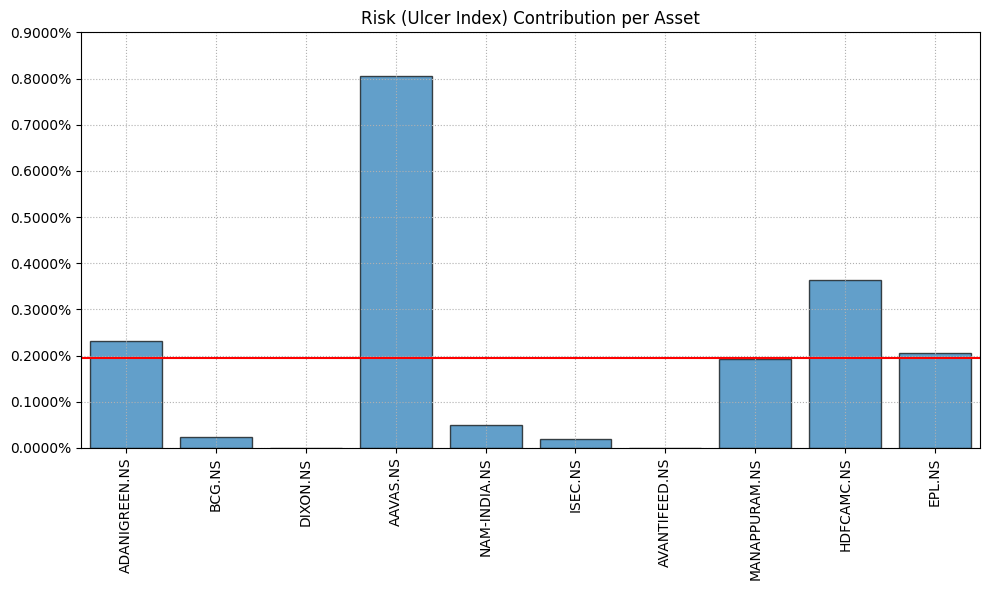

In [26]:
ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

[*********************100%%**********************]  10 of 10 completed


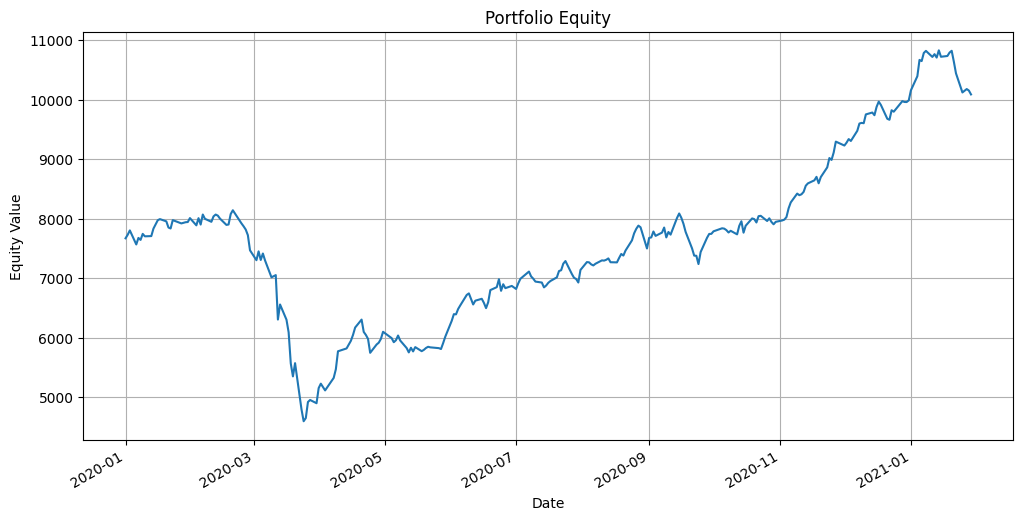

In [28]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd

# Get today's date
today = pd.Timestamp.today().strftime('%Y-%m-%d')

# Define stock symbols and weights
symbols = assets
weights = [1,1,1,1,1,1,1,1,1,1]
# Download historical price data
data = yf.download(symbols, start="2020-01-01", end='2021-01-31')["Adj Close"]

# Calculate portfolio return by multiplying weights with daily returns
portfolio_return = (data * weights).sum(axis=1)

# Plot the portfolio return
plt.figure(figsize=(12, 6))
portfolio_return.plot(title="Portfolio Equity")
plt.ylabel("Equity Value")
plt.xlabel("Date")
plt.grid(True)
plt.show()

February 2024

|index|OFSS\.NS|PFC\.NS|HINDPETRO\.NS|PNB\.NS|DLF\.NS|GICRE\.NS|IOC\.NS|ADANIPORTS\.NS|NHPC\.NS|BAJAJ-AUTO\.NS|
|---|---|---|---|---|---|---|---|---|---|---|
|weights|11\.369589812358923|20\.052978999269733|13\.140136075115278|11\.754298083341052|0\.0004881335353018651|13\.209756686041954|8\.634034436208067|9\.234507501854768|8\.991530442658123|3\.6126798296168015|


January 2024

|index|PFC\.NS|OFSS\.NS|NHPC\.NS|GICRE\.NS|AUROPHARMA\.NS|BAJAJ-AUTO\.NS|NMDC\.NS|PNB\.NS|DLF\.NS|HINDPETRO\.NS|
|---|---|---|---|---|---|---|---|---|---|---|
|weights|19\.9359517241607|11\.644344545584069|8\.119085100588297|12\.482069877947783|7\.860525413315095|2\.992422884219905|9\.734022841420229|12\.332839597407245|1\.374861273536692|13\.523876741819981|
